# DUC Datathon 2020
## Predicting Total Vertical Depth (TVD)

In this section of the competition we are tasked with building regression machine learning (or other)
model that will be able to predict TVD (True Vertical Depth)

In [25]:
# import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import prediction libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Data Import

In [26]:
# import well header data
well_header = pd.read_csv("../data/WellHeader_Datathon.csv")
# get submission ids for testing
submission_sample = pd.read_csv("../data/Submission_Sample.csv")

Selection of features to use, here are the feature types:

* **Labels** : EPAssetsId
* **Numeric**: TVD, total depth, KB elevation
* **Geographic**: Surface latitude and longitude
* **Categorical**: Well Profile, Field, formation

Note that the `field` feature will only be used for checking the latitude/longitude clustering.

### Data Cleaning

The data contains `NAN` values of `TVD` that do not need to be predicted. In the next step we filter out these values and only leave the wells that are on the `submission_sample` dataset or that contain real values of `TVD` that we can use to do the training on. 

In [27]:
# get ids for submission
EPAssetId_submission = submission_sample['EPAssetsId']

# filter well header to only include training points (non-NAN TVD) and submission ifs
well_header = well_header[
      (well_header['EPAssetsId'].isin(EPAssetId_submission)) | (pd.notna(well_header.TVD))]

well_header = well_header[[
                        'EPAssetsId',
                        'TVD','TotalDepth','Formation',
                        'Surf_Longitude','Surf_Latitude',
                        'BH_Longitude','BH_Latitude',
                        'WellProfile','Field','KBElevation',
                        "Licensee",'LicenceDate'
                        ]]

well_header.sample(10)

EPAssetsId      TVD  TotalDepth Formation  Surf_Longitude  \
2659     2612882  2518.05      4175.0   Montney     -119.811777   
3069     2620745      NaN      5641.0   Montney     -118.538604   
1615     2598126   731.77      1474.0    Viking     -113.266879   
5311     1164655   694.98      1477.0    Viking     -109.267861   
1802     2600560   744.91      2235.0    Viking     -110.287551   
54       2613031  3139.74      4378.0  Duvernay     -116.849510   
4925     1166918   637.94      1435.0    Viking     -108.753667   
495      2608537  1703.82      3299.0   Cardium     -115.472711   
5965     1160965   710.50      1550.0    Viking     -109.232196   
406      2619821  2254.25      4004.0   Cardium     -117.027805   

      Surf_Latitude  BH_Longitude  BH_Latitude  WellProfile  \
2659      55.567996   -119.835797    55.576764  Directional   
3069      54.450937   -118.512668    54.432178  Directional   
1615      53.940082   -113.265536    53.947836   Horizontal   
5311      51.872520   -109.269018    51.880616   Horizontal   
1802      51.940531   -110.290104    51.926470   Horizontal   
54        54.371031   -116.848896    54.381715  Directional   
4925      51.795361   -108.754939    51.787413   Horizontal   
495       53.309402   -115.466293    53.295302   Horizontal   
5965      51.839611   -109.218626    51.840770   Horizontal   
406       53.727137   -117.030922    53.744467  Directional   

                  Field  KBElevation                               Licensee  \
2659  Pouce Coupe South        875.9               Advantage Oil & Gas Ltd.   
3069              Kakwa        946.2          Seven Generations Energy Ltd.   
1615           Redwater        656.2              Long Run Exploration Ltd.   
5311          Kerrobert        701.8                     Baytex Energy Ltd.   
1802            Provost        729.4              Rolling Hills Energy Ltd.   
54         Kaybob South        896.2                 Chevron Canada Limited   
4925             Plenty        638.7                      Teine Energy Ltd.   
495             Pembina        955.1                Whitecap Resources Inc.   
5965          Kerrobert        704.9                      Teine Energy Ltd.   
406            Sundance       1148.5  Peyto Exploration & Development Corp.   

     LicenceDate  
2659   5/30/2018  
3069    5/1/2019  
1615   12/1/2016  
5311   3/21/2017  
1802   1/17/2017  
54     5/31/2018  
4925   9/18/2017  
495   11/17/2017  
5965   5/12/2016  
406    2/21/2019

### Data Exploration

First, we can look a few cross-plots of certain variables of interest.

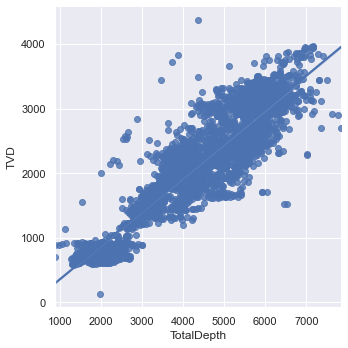

In [28]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", 
            data=well_header, fit_reg=True, height= 5, legend=True);

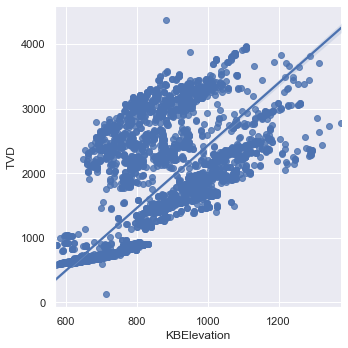

In [29]:
sns.set()
sns.lmplot( x="KBElevation", y="TVD", 
            # hue = 'WellProfile',
            data=well_header, fit_reg=True, height= 5, legend=True);

We can see from the two plots above that both `KVElevation` and `TotalDepth` are strongly correlated to `TVD`

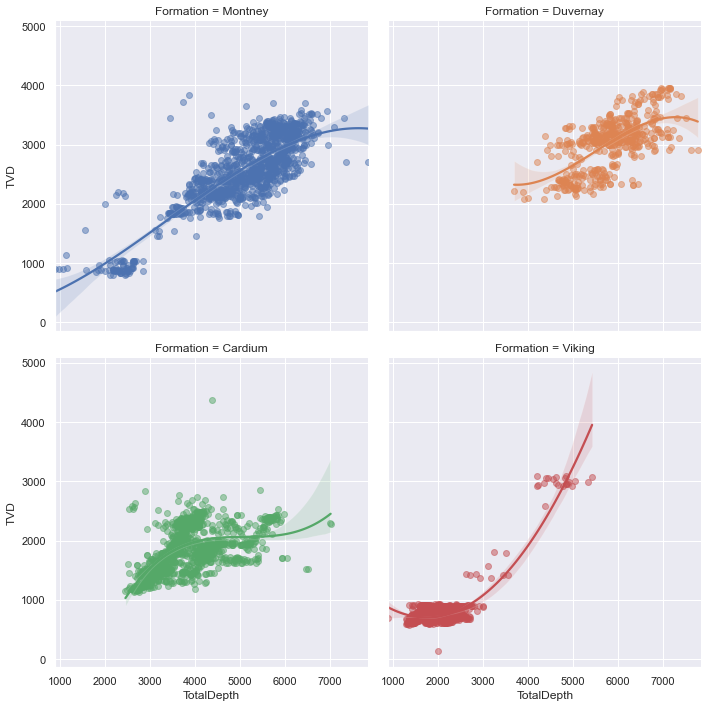

In [30]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=True,hue='Formation',legend=False,col="Formation",col_wrap=2, height=5,order=3,
            scatter_kws={'alpha':0.5});

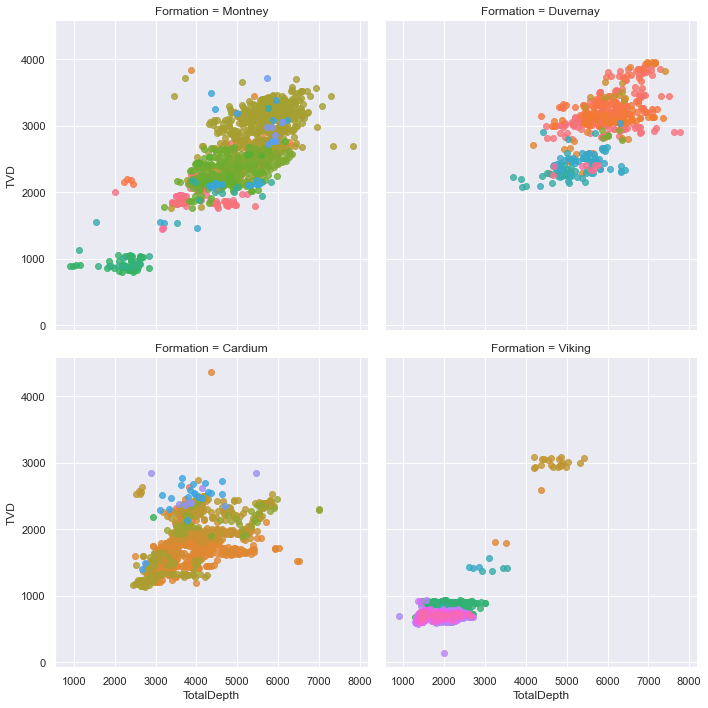

In [31]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=False,hue='Field',legend=False,col="Formation",col_wrap=2, height=5);

The two plots above show that both `Formation` and `Field` are important contributors to the prediction of TVD.

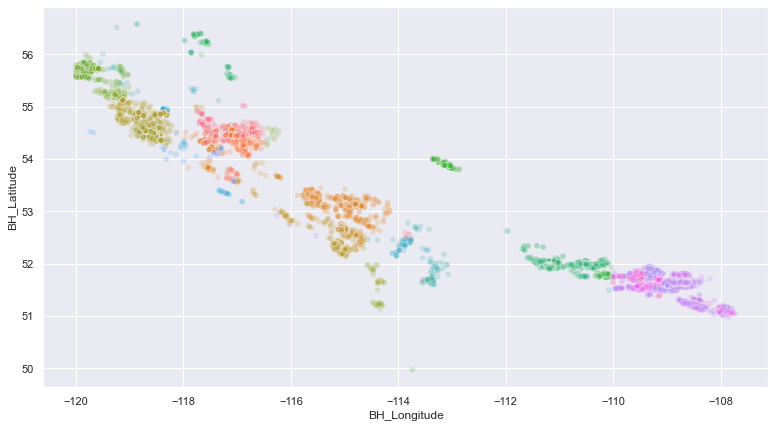

In [32]:
# label field column (for cluster metrics comparisons)
well_header['Field'] = well_header['Field'].astype('category')
well_header['Field_code'] = well_header['Field'].cat.codes

# quick plot
sns.set()
plt.figure(figsize = (13,7))
sns.scatterplot(well_header['BH_Longitude'], 
                well_header['BH_Latitude'],alpha=0.2,
                hue=well_header['Field'],legend=False
                )

We can see above that the data is clustered in certain geographical oil and gas fields. Below we use a clustering method called Density-based spatial clustering of applications with noise (DBSCAN).

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. In our case, this is benefitial.

For further information :

* https://en.wikipedia.org/wiki/DBSCAN
* https://scikit-learn.org/stable/modules/clustering.html#dbscan  

In our case, we use the `Field` feature as a metric on how the clusterin performs. However, the `Field` feature is not used in the final modelling.

In [33]:
# Compute DBSCAN clustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

# cluster lat long coordinates
lat_longs = well_header[[
    'Surf_Longitude','Surf_Latitude',
    # 'BH_Longitude','BH_Latitude'
    ]]
db = DBSCAN(eps=0.1, min_samples=3).fit(lat_longs)

# get sample
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels_true = np.array(well_header.Field_code)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print out metrics
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lat_longs, labels))

Estimated number of clusters: 45
Estimated number of noise points: 57
Homogeneity: 0.581
Completeness: 0.906
V-measure: 0.708
Adjusted Rand Index: 0.283
Adjusted Mutual Information: 0.694
Silhouette Coefficient: 0.349


Below we run the clustering again but this time with a predicted output of cluster labels (using sci-kit learn function `fit_predict`)

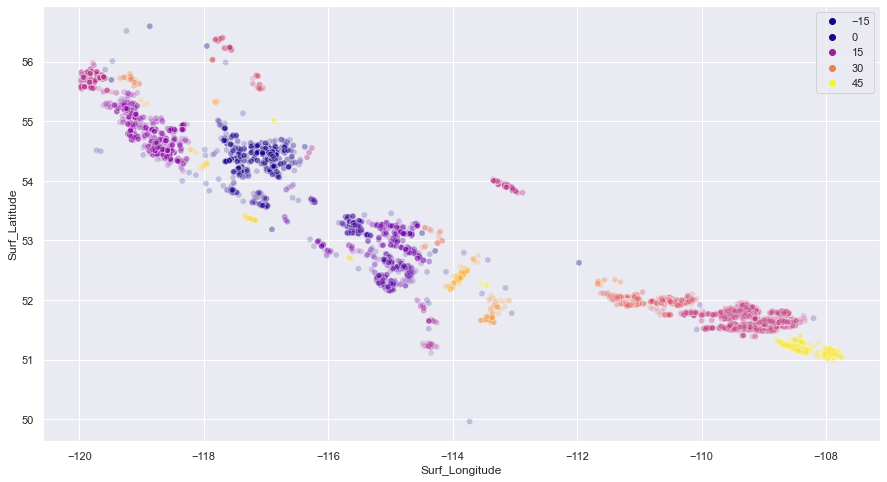

In [34]:
# re-run with prediction values
db = DBSCAN(eps=0.1, min_samples = 3)
clusters = db.fit_predict(lat_longs)

# quick plot with clusters
plt.figure(figsize = (15,8))
sns.scatterplot(well_header['Surf_Longitude'], 
                well_header['Surf_Latitude'],
                alpha=0.2,hue=clusters,palette="plasma")

# add clusters back to df
well_header['DBSCAN_Clusters']=clusters


Select colummns of interest

In [44]:
well_header_clean = well_header[[
                              'EPAssetsId',
                              'TVD',
                              'TotalDepth', 
                              'KBElevation',
                              'Formation', 'WellProfile','DBSCAN_Clusters',
                              "Licensee",'LicenceDate'
                              ]]

well_header_clean['LicenceDate'] = pd.to_datetime(well_header_clean.LicenceDate)

well_header_clean['UnixTime'] = (well_header_clean['LicenceDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')  

# remove noisy clusters?
# well_header_clean = well_header_clean[well_header_clean['DBSCAN_Clusters']>-1]

# add number of wells from the same pad
# pad_locations = pd.read_csv("../data/second_attempt_ese.csv")                              
# pad_locations = pad_locations[['EPAssetsId','True Pad Check_1']]
# well_header_clean = well_header_clean.merge(pad_locations,on='EPAssetsId',how='left')

well_header_clean.sample(10)

EPAssetsId      TVD  TotalDepth  KBElevation Formation  WellProfile  \
6586      1163628   705.76      1976.0        702.0    Viking   Horizontal   
4016      1150374   725.80      1477.5        708.9    Viking   Horizontal   
1082      2615742  3195.80      5636.0        945.1   Montney  Directional   
3234      2618512      NaN      5458.0        890.7   Montney  Directional   
10028     2586420  1970.48      4503.0        965.5   Cardium   Horizontal   
2403      2588444   960.96      1868.0        758.0   Montney   Horizontal   
9687      1174406      NaN      2013.0        680.5    Viking   Horizontal   
9905      2579763  2359.81      4850.0        879.7  Duvernay   Horizontal   
3317      2595553      NaN      7049.0       1076.4  Duvernay   Horizontal   
10232     2610673  1406.36      3217.0        858.8   Cardium   Horizontal   

       DBSCAN_Clusters                 Licensee LicenceDate    UnixTime  
6586                20  Whitecap Resources Inc.  2017-01-13  1484265600  
4016                20       Baytex Energy Ltd.  2014-12-16  1418688000  
1082                12      Nuvista Energy Ltd.  2018-09-13  1536796800  
3234                38       Velvet Energy Ltd.  2018-12-19  1545177600  
10028                6     Obsidian Energy Ltd.  2015-03-18  1426636800  
2403                22      Canamax Energy Ltd.  2010-03-11  1268265600  
9687                20  Whitecap Resources Inc.  2019-06-14  1560470400  
9905                36        Vesta Energy Ltd.  2014-09-17  1410912000  
3317                 0       Ovintiv Canada Ulc  2016-08-30  1472515200  
10232                8    Bonterra Energy Corp.  2018-01-30  1517270400

### Predicting TVD using the Random Forests alorithm

In [22]:
# extract data to use in the validation stage
well_header_validation = well_header_clean[pd.isna(well_header_clean.TVD)]

# get unique values of formation, clusters, and well profile 
# from validation set to filter the training set
validation_clusters = well_header_validation.DBSCAN_Clusters.unique()
validation_formation = well_header_validation.Formation.unique()
validation_profile = well_header_validation.WellProfile.unique()

# filter training set
well_header_train = well_header_clean[pd.notna(well_header_clean.TVD)][
        well_header_clean.DBSCAN_Clusters.isin(validation_clusters)][
        well_header_clean.Formation.isin(validation_formation)][
        well_header_clean.WellProfile.isin(validation_profile)]

Above we filter the data further so that the traning set contains the same unique features as the validation set, thereby obtaining a model that will match the validation set.

Below we split the training set into a test and training set to fit the model. We'll use the model on the validation set for prediction.

In [29]:
features = [
            'TotalDepth',
            'Formation',
            'WellProfile',
            'KBElevation',
            'DBSCAN_Clusters']

target = ['TVD']

X = well_header_train[features]
y = well_header_train[target]

# hot encode categorical variables
X = pd.get_dummies(X, 
                    columns=[
                            "Formation", 
                            "WellProfile",
                            "DBSCAN_Clusters"], 
                    prefix=["fm", "profile","dbscan_cluster"])

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

# fit regressor
regr = RandomForestRegressor(
                max_depth=15
                )
regr.fit(X, y)

# get prediction
y_prediction = regr.predict(X_test)

# get RMSE
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print("The test RMSE is :",RMSE)


The test RMSE is : 27.11837187507859


### Predict and write TVD to file for submission

In [30]:
X_validation = well_header_validation[features]

# hot encode
X_validation = pd.get_dummies(X_validation, 
                    columns=[
                            "Formation", 
                            "WellProfile",
                            "DBSCAN_Clusters"], 
                    prefix=["fm", "profile","dbscan_cluster"])

# get prediction
y_validation = regr.predict(X_validation)

well_header_submission = well_header_validation['EPAssetsId'].to_frame()

well_header_submission['TVD'] = y_validation

well_header_submission.to_csv("../predictions/predicted_tvd.csv",index=False)

In [31]:
well_header_submission

EPAssetsId          TVD
0         2587301  1890.739481
8         2608978  1859.917428
14        2608702  3050.088100
15        2614267  3050.085600
17        2608700  3031.465300
...           ...          ...
10422     2593752   890.728438
10424     2588281   883.876463
10427     2588282   882.895328
10428     2588283   881.680033
10433     2621490   898.912245

[1963 rows x 2 columns]